### Standard Imports

In [1]:
import sys
import os

sys.path.append(os.path.join(os.getcwd(), "..", "."))  # add parent dir to path

import numpy as np
from tqdm.notebook import tqdm

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import matplotlib.pyplot as plt
import torchinfo

# Custom imports
from config import *
from data import *

# Use STIX font for math plotting
plt.rcParams["font.family"] = "STIXGeneral"

import torchvision
from torchvision import transforms
from termcolor import colored
import warnings

warnings.filterwarnings("ignore")

cfg = get_mnist_config()
print(colored(f"Config:", "green"))
print(cfg)

device = torch.device("cuda:0") if torch.cuda.is_available() else torch.device("cpu")
print(colored(f"Using device:", "green"), device)

# Seed for reproducability
# Ensure that all operations are deterministic on GPU (if used) for reproducibility
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False
torch.manual_seed(cfg.seed)
np.random.seed(np.array(cfg.seed))

Config:
batch_size: 32
data_root: /home/zonularity/aecc/data
lr: 0.001
lr_gamma: 0.1
lr_step_size: 15
model_dir: /home/zonularity/aecc/weights
noise_factor: 0.15
num_epochs: 30
num_workers: 4
pin_memory: true
seed: 42
weight_decay: 0.0001

Using device: cuda:0


### Data Loading and Visualization

In [2]:
# MNISt dataset
train_dataset = torchvision.datasets.MNIST(
    root=cfg.data_root,
    train=True,
    transform=transforms.ToTensor(),
    download=True,
)
test_dataset = torchvision.datasets.MNIST(
    root=cfg.data_root,
    train=False,
    transform=transforms.ToTensor(),
    download=True,
)

# Split the training dataset into training and validation datasets
train_size = int(0.8 * len(train_dataset))
val_size = len(train_dataset) - train_size
train_dataset, val_dataset = torch.utils.data.random_split(
    train_dataset, [train_size, val_size]
)

# Create dataloaders
train_loader = torch.utils.data.DataLoader(
    train_dataset,
    batch_size=cfg.batch_size,
    shuffle=True,
    num_workers=cfg.num_workers,
)
val_loader = torch.utils.data.DataLoader(
    val_dataset,
    batch_size=cfg.batch_size,
    shuffle=True,
    num_workers=cfg.num_workers,
)
test_loader = torch.utils.data.DataLoader(
    test_dataset,
    batch_size=cfg.batch_size,
    shuffle=False,
    num_workers=cfg.num_workers,
)

print(colored(f"Train loader batches:", "green"), len(train_loader))
print(colored(f"Test loader batches:", "green"), len(test_loader))

Train loader batches: 1500
Test loader batches: 313


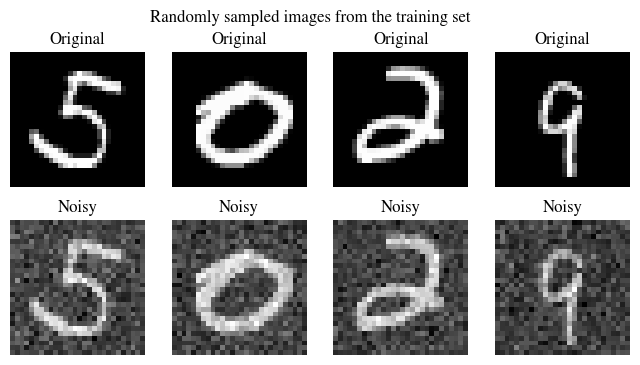

In [3]:
# Visualize 4 images; both original and noisy
fig, ax = plt.subplots(2, 4, figsize=(8, 4))
fig.suptitle("Randomly sampled images from the training set")

for i, (img, _) in enumerate(train_loader):
    if i == 4:
        break
    noisy_img = img + torch.randn_like(img) * cfg.noise_factor
    ax[0, i].imshow(img[0].permute(1, 2, 0), cmap="gray")
    ax[0, i].set_title("Original")
    ax[0, i].axis("off")
    ax[1, i].imshow(noisy_img[0].permute(1, 2, 0), cmap="gray")
    ax[1, i].set_title("Noisy")
    ax[1, i].axis("off")
plt.show()

### Image to Patches

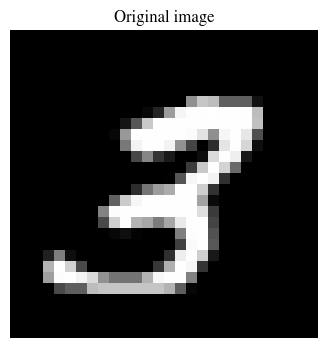

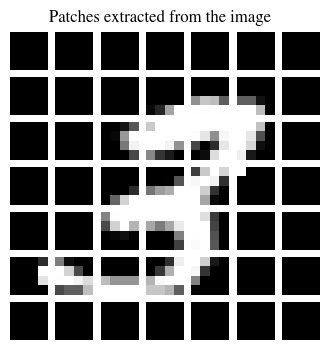

In [4]:
def extract_patches(batch, patch_size):
    """
    Extract patches from a batch of images.

    Args:
        batch: batch of images
        patch_size: size of the patch to be extracted
    """
    b, c, h, w = batch.shape
    assert (
        h % patch_size[0] == 0 and w % patch_size[1] == 0
    ), "Patch size should be a factor of image height and width"

    ph, pw = patch_size  # patch height and width
    nh, nw = h // ph, w // pw  # number of patches along height and width

    batch_patches = torch.reshape(batch, (b, c, nh, ph, nw, pw))
    batch_patches = torch.permute(batch_patches, (0, 1, 2, 4, 3, 5))

    return batch_patches


imgs, _ = next(iter(train_loader))
img_patches = extract_patches(imgs, (4, 4))

# Visualize one image and its patches
patches = img_patches[0]
c, nh, nw, ph, pw = patches.shape

plt.figure(figsize=(4, 4))
plt.imshow(imgs[0].permute(1, 2, 0), cmap="gray")
plt.title("Original image")
plt.axis("off")

plt.figure(figsize=(4, 4))
for i in range(nh):
    for j in range(nw):
        plt.subplot(nh, nw, i * nw + j + 1)
        plt.imshow(patches[:, i, j].permute(1, 2, 0), cmap="gray")
        plt.axis("off")
        plt.suptitle("Patches extracted from the image", y=0.935)

### Autoencoder

In [5]:
"""
The idea is to model the transmission of images [of shape 224x224x3] through a
noisy (wireless) channel using an autoencoder. The encoder is trained to compress 
the image into a latent vector, which is then transmitted through the channel. 
The decoder is trained to reconstruct the image from the latent vector. The 
encoder and decoder are trained jointly to minimize the reconstruction loss.

The encoder used a vision transformer (ViT) encoder, which takes in patches of 
the image as input. The decoder used transposed convolutions to upsample the 
latent vector into an image. The encoder and decoder are trained jointly to 
minimize the reconstruction loss.
"""

# Parameters
img_size = (28, 28)  # size of the image
patch_size = (4, 4)  # size of the patch
num_channels = 1  # number of channels in the image
proj_dim = 64  # dimension of the projection head
num_heads = 4  # number of heads in the transformer encoder
dim_feedforward = 128  # dimension of the feedforward network in transformer encoder
blocks = 2  # number of transformer encoder blocks
mlp_units = [2048, 1024]  # units in the MLP of the projection head
latent_dim = 16  # dimension of the latent vector

In [6]:
class Img2Seq(nn.Module):
    """
    Image to sequence model.

    Args:
        img_size: size of the image
        patch_size: size of the patch to be extracted
        num_channels: number of channels in the image
        proj_dim: projection dimension
    """

    def __init__(self, img_size, patch_size, num_channels, proj_dim):
        super().__init__()
        self.patch_size = patch_size
        self.img_size = img_size

        nh, nw = img_size[0] // patch_size[0], img_size[1] // patch_size[1]
        n_tokens = nh * nw

        token_dim = patch_size[0] * patch_size[1] * num_channels
        self.linear = nn.Linear(token_dim, proj_dim)
        self.cls_token = nn.Parameter(torch.randn(1, 1, proj_dim))
        self.pos_emb = nn.Parameter(torch.randn(n_tokens, proj_dim))

    def forward(self, batch):
        batch = extract_patches(batch, self.patch_size)
        b, c, nh, nw, ph, pw = batch.shape

        # Flatten the patches
        batch = torch.permute(batch, (0, 2, 3, 4, 5, 1))
        batch = torch.reshape(batch, (b, nh * nw, ph * pw * c))

        batch = self.linear(batch)
        cls_token = self.cls_token.expand(b, -1, -1)
        emb = batch + self.pos_emb
        batch = torch.cat((cls_token, emb), dim=1)

        return batch


class MLP(nn.Module):
    def __init__(self, in_features, hidden_units, out_features):
        super().__init__()
        self.layers = self._build_layers(in_features, hidden_units, out_features)

    def _build_layers(self, in_features, hidden_units, out_features):
        dims = [in_features] + hidden_units + [out_features]
        layers = []

        for dim1, dim2 in zip(dims[:-2], dims[1:-1]):
            layers.append(nn.Linear(dim1, dim2))
            layers.append(nn.ReLU())

        layers.append(nn.Linear(dims[-2], dims[-1]))
        return nn.Sequential(*layers)

    def forward(self, x):
        return self.layers(x)


class ViT(nn.Module):
    def __init__(
        self,
        img_size,
        patch_size,
        num_channels,
        proj_dim,
        num_heads,
        dim_feedforward,
        blocks,
        mlp_units,
        latent_dim,
    ):
        super().__init__()
        self.img2seq = Img2Seq(img_size, patch_size, num_channels, proj_dim)

        encoder_layer = nn.TransformerEncoderLayer(
            proj_dim, num_heads, dim_feedforward, activation="gelu", batch_first=True
        )
        self.transformer_encoder = nn.TransformerEncoder(encoder_layer, blocks)

        # Add a fully connected layer for classification
        self.flatten = nn.Flatten()
        self.dropout = nn.Dropout(0.25)

        self.mlp = MLP(
            3200,  # adjust this to match the output of the transformer encoder
            mlp_units,
            latent_dim,
        )

    def forward(self, batch):
        batch = self.img2seq(batch)
        batch = self.transformer_encoder(batch)

        # Flatten the output of the transformer encoder
        batch = self.flatten(batch)
        batch = F.layer_norm(batch, batch.shape[1:])
        batch = self.dropout(batch)

        # Pass the flattened output to the classifier
        batch = self.mlp(batch)

        return batch


# Test the ViT encoder
x = torch.randn(cfg.batch_size, num_channels, *img_size)
x = x.to(device)
vit = ViT(
    img_size,
    patch_size,
    num_channels,
    proj_dim,
    num_heads,
    dim_feedforward,
    blocks,
    mlp_units,
    latent_dim,
)

vit.to(device)
out = vit(x)
print("Output shape:", out.shape)

Output shape: torch.Size([32, 16])


In [7]:
torchinfo.summary(vit, input_size=(cfg.batch_size, num_channels, *img_size))

Layer (type:depth-idx)                        Output Shape              Param #
ViT                                           [32, 16]                  --
├─Img2Seq: 1-1                                [32, 50, 64]              3,200
│    └─Linear: 2-1                            [32, 49, 64]              1,088
├─TransformerEncoder: 1-2                     [32, 50, 64]              --
│    └─ModuleList: 2-2                        --                        --
│    │    └─TransformerEncoderLayer: 3-1      [32, 50, 64]              33,472
│    │    └─TransformerEncoderLayer: 3-2      [32, 50, 64]              33,472
├─Flatten: 1-3                                [32, 3200]                --
├─Dropout: 1-4                                [32, 3200]                --
├─MLP: 1-5                                    [32, 16]                  --
│    └─Sequential: 2-3                        [32, 16]                  --
│    │    └─Linear: 3-3                       [32, 2048]                6,555,648

In [8]:
class Decoder(nn.Module):
    def __init__(self, latent_dim, num_channels):
        super(Decoder, self).__init__()
        self.fc = nn.Linear(latent_dim, 8 * 7 * 7)
        self.conv1 = nn.ConvTranspose2d(
            8, 8, kernel_size=3, stride=2, padding=1, output_padding=1
        )
        self.conv2 = nn.ConvTranspose2d(
            8, 16, kernel_size=3, stride=2, padding=1, output_padding=1
        )
        self.conv3 = nn.Conv2d(16, num_channels, kernel_size=3, padding=1)

    def forward(self, x):
        x = F.relu(self.fc(x))
        x = x.view(-1, 8, 7, 7)  # reshape operation
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = torch.sigmoid(self.conv3(x))
        return x


class DenoisingAutoencoder(nn.Module):
    def __init__(
        self,
        img_size,
        patch_size,
        num_channels,
        proj_dim,
        num_heads,
        dim_feedforward,
        blocks,
        mlp_units,
        latent_dim,
    ):
        super().__init__()  # Call parent's __init__ method first

        self.encoder = ViT(
            img_size,
            patch_size,
            num_channels,
            proj_dim,
            num_heads,
            dim_feedforward,
            blocks,
            mlp_units,
            latent_dim,
        )

        self.decoder = Decoder(latent_dim, num_channels)

    def forward(self, batch):
        batch = self.encoder(batch)
        batch = self.decoder(batch)
        return batch


# Test the denoising autoencoder
x = torch.randn(cfg.batch_size, num_channels, *img_size)
x = x.to(device)

dae = DenoisingAutoencoder(
    img_size,
    patch_size,
    num_channels,
    proj_dim,
    num_heads,
    dim_feedforward,
    blocks,
    mlp_units,
    latent_dim,
)

dae.to(device)
out = dae(x)
print("Output shape:", out.shape)

Output shape: torch.Size([32, 1, 28, 28])


### Training

In [9]:
criterion = nn.MSELoss()
optimizer = optim.Adam(dae.parameters(), lr=cfg.lr)
learning_rate_scheduler = optim.lr_scheduler.StepLR(
    optimizer, step_size=cfg.lr_step_size, gamma=cfg.lr_gamma
)

# Training loop
train_loss = []
val_loss = []

for epoch in range(cfg.num_epochs):
    # Train
    dae.train()
    train_epoch_loss = 0.0
    with tqdm(
        train_loader, desc=f"Epoch {epoch+1}/{cfg.num_epochs}", unit="batch"
    ) as train_bar:
        for i, (imgs, _) in enumerate(train_bar):
            noisy_imgs = imgs + cfg.noise_factor * torch.randn(*imgs.shape)
            noisy_imgs = torch.clamp(noisy_imgs, 0.0, 1.0)
            imgs = imgs.to(device)
            noisy_imgs = noisy_imgs.to(device)

            optimizer.zero_grad()
            out = dae(noisy_imgs)
            loss = criterion(out, imgs)
            loss.backward()
            optimizer.step()

            train_epoch_loss += loss.item()
            train_bar.set_postfix(train_loss=train_epoch_loss / (i + 1))

    train_loss.append(train_epoch_loss / len(train_loader))

    # Validation
    dae.eval()
    val_epoch_loss = 0.0
    with torch.no_grad():
        for imgs, _ in val_loader:
            noisy_imgs = imgs + cfg.noise_factor * torch.randn(*imgs.shape)
            noisy_imgs = torch.clamp(noisy_imgs, 0.0, 1.0)
            imgs = imgs.to(device)
            noisy_imgs = noisy_imgs.to(device)

            out = dae(noisy_imgs)
            loss = criterion(out, imgs)
            val_epoch_loss += loss.item()

    val_loss.append(val_epoch_loss / len(val_loader))

    learning_rate_scheduler.step()

    # Log results
    print(
        colored("Epoch", "green")
        + f" {epoch+1}/{cfg.num_epochs} | "
        + colored("Train loss:", "yellow")
        + f" {train_epoch_loss/len(train_loader):.5f} | "
        + colored("Validation loss:", "red")
        + f" {val_epoch_loss/len(val_loader):.5f}"
    )

Epoch 1/30:   0%|          | 0/1500 [00:00<?, ?batch/s]

Epoch 1/30 | Train loss: 0.07516 | Validation loss: 0.06075


Epoch 2/30:   0%|          | 0/1500 [00:00<?, ?batch/s]

Epoch 2/30 | Train loss: 0.05198 | Validation loss: 0.03430


Epoch 3/30:   0%|          | 0/1500 [00:00<?, ?batch/s]

Epoch 3/30 | Train loss: 0.02668 | Validation loss: 0.02110


Epoch 4/30:   0%|          | 0/1500 [00:00<?, ?batch/s]

Epoch 4/30 | Train loss: 0.01980 | Validation loss: 0.01765


Epoch 5/30:   0%|          | 0/1500 [00:00<?, ?batch/s]

Epoch 5/30 | Train loss: 0.01701 | Validation loss: 0.01561


Epoch 6/30:   0%|          | 0/1500 [00:00<?, ?batch/s]

Epoch 6/30 | Train loss: 0.01545 | Validation loss: 0.01476


Epoch 7/30:   0%|          | 0/1500 [00:00<?, ?batch/s]

Epoch 7/30 | Train loss: 0.01445 | Validation loss: 0.01339


Epoch 8/30:   0%|          | 0/1500 [00:00<?, ?batch/s]

Epoch 8/30 | Train loss: 0.01373 | Validation loss: 0.01330


Epoch 9/30:   0%|          | 0/1500 [00:00<?, ?batch/s]

Epoch 9/30 | Train loss: 0.01324 | Validation loss: 0.01279


Epoch 10/30:   0%|          | 0/1500 [00:00<?, ?batch/s]

Epoch 10/30 | Train loss: 0.01291 | Validation loss: 0.01280


Epoch 11/30:   0%|          | 0/1500 [00:00<?, ?batch/s]

Epoch 11/30 | Train loss: 0.01261 | Validation loss: 0.01218


Epoch 12/30:   0%|          | 0/1500 [00:00<?, ?batch/s]

Epoch 12/30 | Train loss: 0.01239 | Validation loss: 0.01232


Epoch 13/30:   0%|          | 0/1500 [00:00<?, ?batch/s]

Epoch 13/30 | Train loss: 0.01218 | Validation loss: 0.01237


Epoch 14/30:   0%|          | 0/1500 [00:00<?, ?batch/s]

Epoch 14/30 | Train loss: 0.01202 | Validation loss: 0.01139


Epoch 15/30:   0%|          | 0/1500 [00:00<?, ?batch/s]

Epoch 15/30 | Train loss: 0.01186 | Validation loss: 0.01180


Epoch 16/30:   0%|          | 0/1500 [00:00<?, ?batch/s]

Epoch 16/30 | Train loss: 0.01100 | Validation loss: 0.01082


Epoch 17/30:   0%|          | 0/1500 [00:00<?, ?batch/s]

Epoch 17/30 | Train loss: 0.01089 | Validation loss: 0.01068


Epoch 18/30:   0%|          | 0/1500 [00:00<?, ?batch/s]

Epoch 18/30 | Train loss: 0.01084 | Validation loss: 0.01066


Epoch 19/30:   0%|          | 0/1500 [00:00<?, ?batch/s]

Epoch 19/30 | Train loss: 0.01081 | Validation loss: 0.01060


Epoch 20/30:   0%|          | 0/1500 [00:00<?, ?batch/s]

Epoch 20/30 | Train loss: 0.01078 | Validation loss: 0.01058


Epoch 21/30:   0%|          | 0/1500 [00:00<?, ?batch/s]

Epoch 21/30 | Train loss: 0.01075 | Validation loss: 0.01053


Epoch 22/30:   0%|          | 0/1500 [00:00<?, ?batch/s]

Epoch 22/30 | Train loss: 0.01072 | Validation loss: 0.01065


Epoch 23/30:   0%|          | 0/1500 [00:00<?, ?batch/s]

Epoch 23/30 | Train loss: 0.01070 | Validation loss: 0.01049


Epoch 24/30:   0%|          | 0/1500 [00:00<?, ?batch/s]

Epoch 24/30 | Train loss: 0.01068 | Validation loss: 0.01044


Epoch 25/30:   0%|          | 0/1500 [00:00<?, ?batch/s]

Epoch 25/30 | Train loss: 0.01066 | Validation loss: 0.01052


Epoch 26/30:   0%|          | 0/1500 [00:00<?, ?batch/s]

Epoch 26/30 | Train loss: 0.01064 | Validation loss: 0.01052


Epoch 27/30:   0%|          | 0/1500 [00:00<?, ?batch/s]

Epoch 27/30 | Train loss: 0.01062 | Validation loss: 0.01055


Epoch 28/30:   0%|          | 0/1500 [00:00<?, ?batch/s]

Epoch 28/30 | Train loss: 0.01060 | Validation loss: 0.01046


Epoch 29/30:   0%|          | 0/1500 [00:00<?, ?batch/s]

Epoch 29/30 | Train loss: 0.01059 | Validation loss: 0.01057


Epoch 30/30:   0%|          | 0/1500 [00:00<?, ?batch/s]

Epoch 30/30 | Train loss: 0.01057 | Validation loss: 0.01063


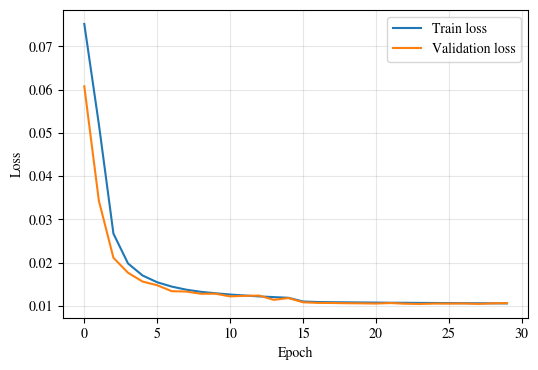

In [10]:
# Visualize the training and validation loss
plt.figure(figsize=(6, 4))
plt.plot(train_loss, label="Train loss")
plt.plot(val_loss, label="Validation loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.grid(alpha=0.3)
plt.legend()
plt.show()

### Save Weights

In [11]:
# Save the model
torch.save(dae.state_dict(), os.path.join(cfg.model_dir, "dae_mnist.pth"))
print(colored(f"Model saved to {cfg.model_dir}", "green"))

Model saved to /home/zonularity/aecc/weights


### Visualize Denoising

In [12]:
dae = DenoisingAutoencoder(
    img_size,
    patch_size,
    num_channels,
    proj_dim,
    num_heads,
    dim_feedforward,
    blocks,
    mlp_units,
    latent_dim,
)
dae.load_state_dict(torch.load(os.path.join(cfg.model_dir, "dae_mnist.pth")))

<All keys matched successfully>

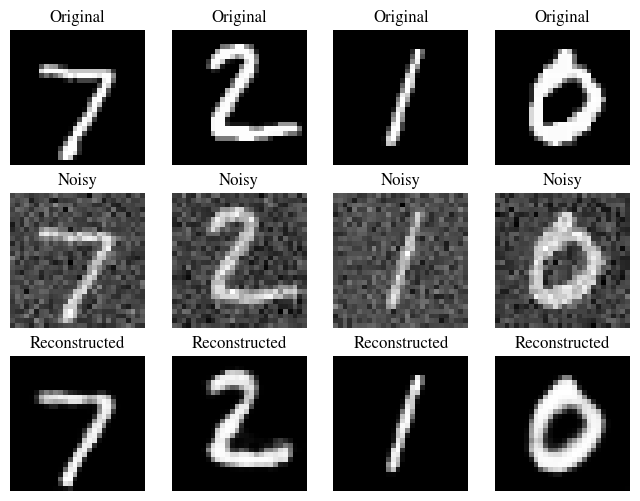

In [13]:
# Visualize the output of the autoencoder
imgs, _ = next(iter(test_loader))
noisy_imgs = imgs + cfg.noise_factor * torch.randn(*imgs.shape)
out = dae(noisy_imgs).detach().cpu()

fig, ax = plt.subplots(3, 4, figsize=(8, 6))

for i in range(4):
    ax[0, i].imshow(imgs[i][0], cmap="gray")
    ax[0, i].set_title("Original")
    ax[0, i].axis("off")
    ax[1, i].imshow(noisy_imgs[i][0], cmap="gray")
    ax[1, i].set_title("Noisy")
    ax[1, i].axis("off")
    ax[2, i].imshow(out[i][0], cmap="gray")
    ax[2, i].set_title("Reconstructed")
    ax[2, i].axis("off")